# TimeGPT Quickstart



## Step 1: Create a TimeGPT account and generate your API key

## Step 2: Install Nixtla

In your favorite Python development environment:

Install `nixtla` with `pip`:
    
```shell
pip install nixtla
```

In [1]:
! pip install nixtla

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 kB 1.7 MB/s eta 0:00:00


## Step 3: Import the Nixtla TimeGPT client

In [2]:
from nixtla import NixtlaClient

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


You can instantiate the `NixtlaClient` class providing your authentication API key.

In [3]:
nixtla_client = NixtlaClient(
    api_key = 'nixak-krpBnhe7uPMyYrAFaTMg0Ect3c982NhpAfyVkCIchcKv0pKuTKzhSK1WsT17RKl2bGwc3RX4xo4fevrN'
)

Check your API key status with the `validate_api_key` method.

In [4]:
nixtla_client.validate_api_key()

True

## Step 4: Start making forecasts!

Now you can start making forecasts! Let's import an example using the classic `AirPassengers` dataset. This dataset contains the monthly number of airline passengers in Australia between 1949 and 1960. First, load the dataset and plot it:

In [5]:
import pandas as pd

In [6]:
df = pd.read_csv('https://raw.githubusercontent.com/Nixtla/transfer-learning-time-series/main/datasets/air_passengers.csv')
df.head()

,timestamp,value
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


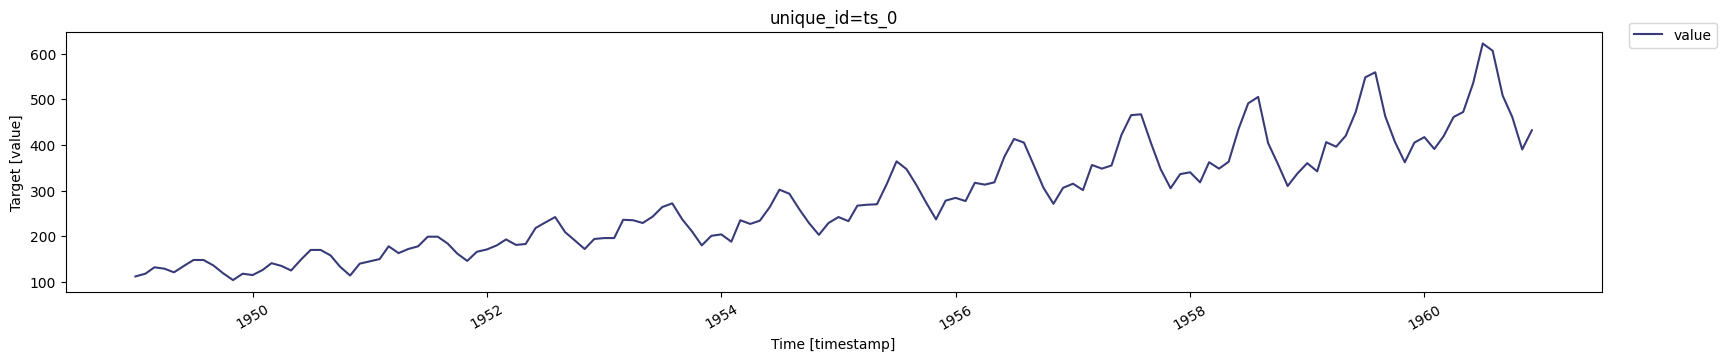

In [8]:
nixtla_client.plot(df, time_col='timestamp', target_col='value')

> 👍 Save figures made with TimeGPT
>
> The `plot` method automatically displays figures when in a notebook environment. To save figures locally, you can do:
>
> `fig = nixtla_client.plot(df, time_col='timestamp', target_col='value')`
>
>`fig.savefig('plot.png', bbox_inches='tight')`

### Forecast a longer horizon into the future

Next, forecast the next 12 months using the SDK `forecast` method. Set the following parameters:

- `df`: A pandas DataFrame containing the time series data.
- `h`: Horizons is the number of steps ahead to forecast.
- `freq`: The frequency of the time series in Pandas format. See [pandas’ available frequencies](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases). (If you don't provide any frequency, the SDK will try to infer it)
- `time_col`: The column that identifies the datestamp.
- `target_col`: The variable to forecast.


In [9]:
timegpt_fcst_df = nixtla_client.forecast(df=df, h=12, freq='MS', time_col='timestamp', target_col='value')
timegpt_fcst_df.head()

,timestamp,TimeGPT
0,1961-01-01,437.83792
1,1961-02-01,426.06270
2,1961-03-01,463.11655
3,1961-04-01,478.24450
4,1961-05-01,505.64648


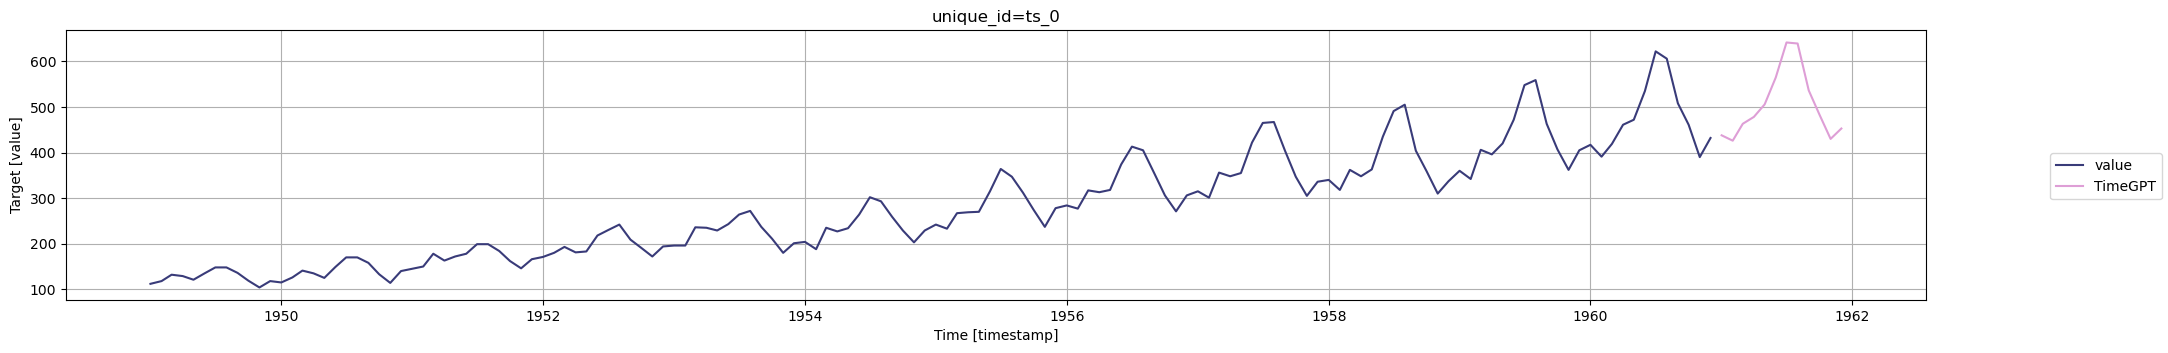

In [ ]:
nixtla_client.plot(df, timegpt_fcst_df, time_col='timestamp', target_col='value')

You can also produce longer forecasts by increasing the horizon parameter and selecting the `timegpt-1-long-horizon` model. Use this model if you want to predict more than one seasonal period of your data.

For example, let's forecast the next 36 months:


In [ ]:
timegpt_fcst_df = nixtla_client.forecast(df=df, h=36, time_col='timestamp', target_col='value', freq='MS', model='timegpt-1-long-horizon')
timegpt_fcst_df.head()

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Restricting input...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


,timestamp,TimeGPT
0,1961-01-01,436.843414
1,1961-02-01,419.351532
2,1961-03-01,458.943146
3,1961-04-01,477.876068
4,1961-05-01,505.656921


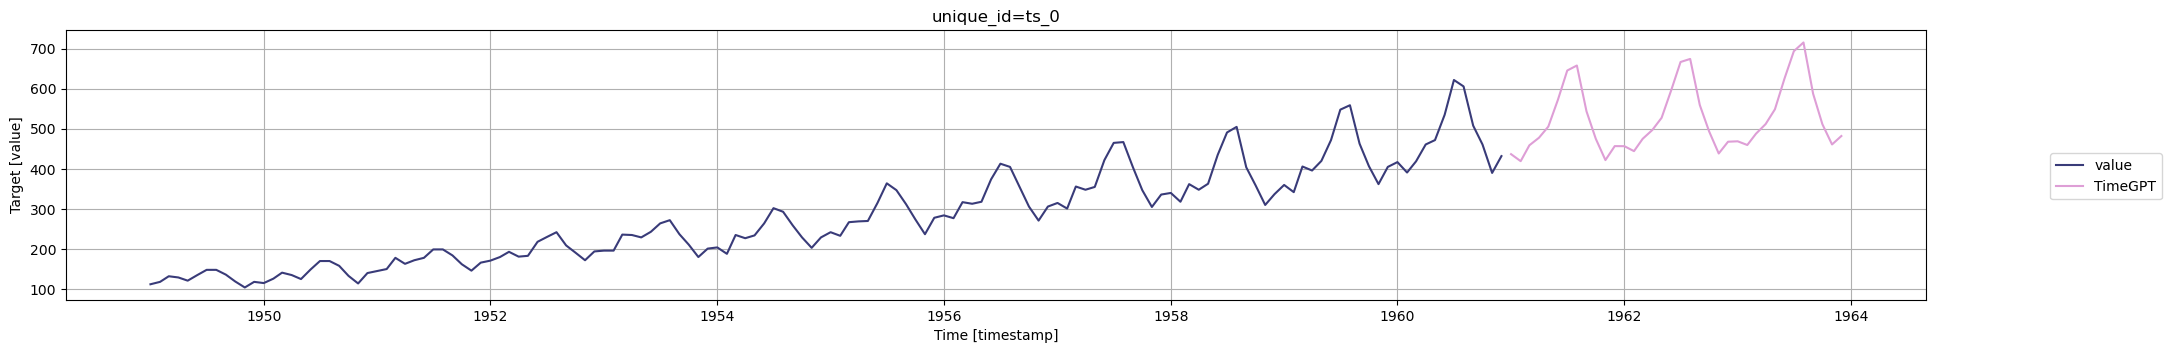

In [ ]:
nixtla_client.plot(df, timegpt_fcst_df, time_col='timestamp', target_col='value')

### Produce a shorter forecast

You can also produce a shorter forecast. For this, we recommend using the default model, `timegpt-1`.

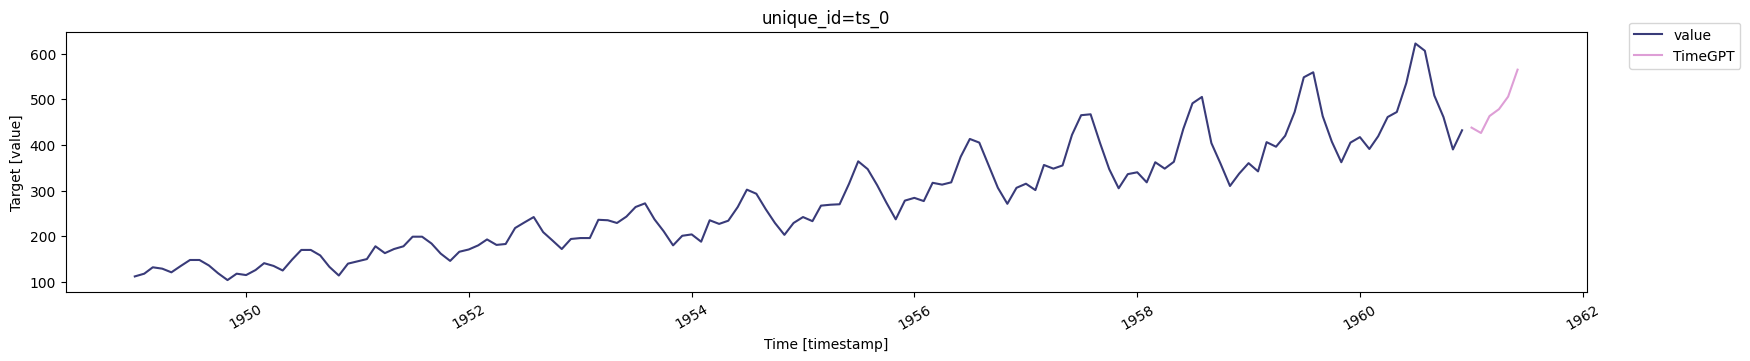

In [10]:
timegpt_fcst_df = nixtla_client.forecast(df=df, h=6, time_col='timestamp', target_col='value', freq='MS')
nixtla_client.plot(df, timegpt_fcst_df, time_col='timestamp', target_col='value')

## Anomoly Detection

In [13]:
df = pd.read_csv('https://datasets-nixtla.s3.amazonaws.com/peyton-manning.csv')
df.head()

,unique_id,ds,y
0,0,2007-12-10,9.590761
1,0,2007-12-11,8.519590
2,0,2007-12-12,8.183677
3,0,2007-12-13,8.072467
4,0,2007-12-14,7.893572


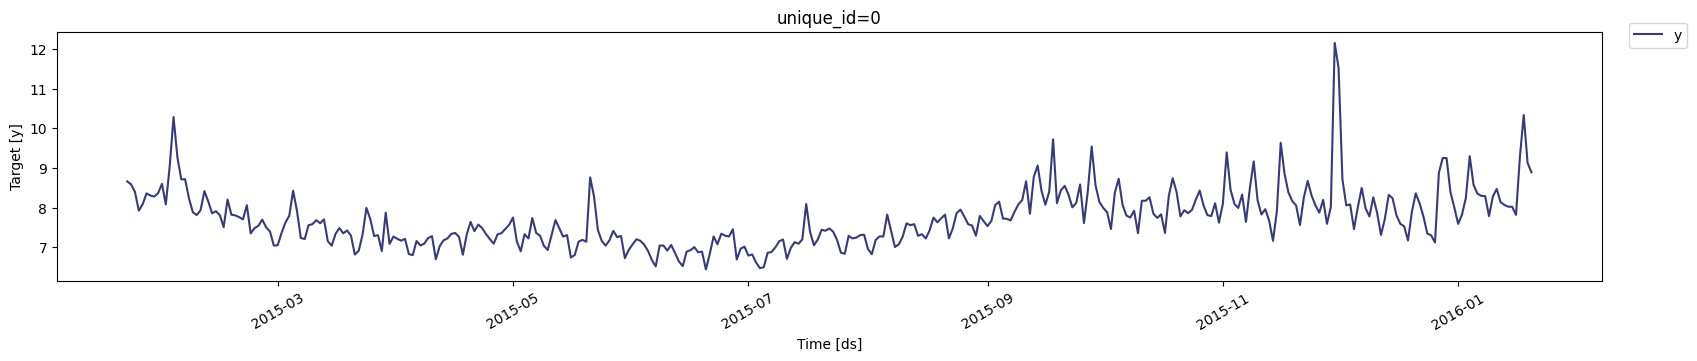

In [15]:
nixtla_client.plot(df, max_insample_length=365)

In [14]:
anomalies_df = nixtla_client.detect_anomalies(df, freq='D')
anomalies_df.head()

,unique_id,ds,y,TimeGPT,TimeGPT-hi-99,TimeGPT-lo-99,anomaly
0,0,2008-01-10,8.281724,8.224187,9.503586,6.944788,False
1,0,2008-01-11,8.292799,8.151533,9.430932,6.872135,False
2,0,2008-01-12,8.199189,8.127243,9.406642,6.847845,False
3,0,2008-01-13,9.996522,8.917259,10.196658,7.637861,False
4,0,2008-01-14,10.127071,9.002326,10.281725,7.722928,False


## Energy Forecasting

In [17]:
import time
import requests
import pandas as pd

from nixtla import NixtlaClient

from utilsforecast.losses import mae, smape
from utilsforecast.evaluation import evaluate

In [18]:
df = pd.read_csv('https://raw.githubusercontent.com/Nixtla/transfer-learning-time-series/refs/heads/main/datasets/pjm_in_zone.csv')
df['ds'] = pd.to_datetime(df['ds'])

In [19]:
df.groupby('unique_id').head(2)


,unique_id,ds,y
0,AP-AP,2023-10-01 04:00:00+00:00,4042.513
1,AP-AP,2023-10-01 05:00:00+00:00,3850.067
8784,DOM-DOM,2023-10-01 04:00:00+00:00,10732.435
8785,DOM-DOM,2023-10-01 05:00:00+00:00,10314.211
17568,JC-JC,2023-10-01 04:00:00+00:00,1825.101
17569,JC-JC,2023-10-01 05:00:00+00:00,1729.590
26352,PN-PN,2023-10-01 04:00:00+00:00,1454.666
26353,PN-PN,2023-10-01 05:00:00+00:00,1416.688
35136,RTO-RTO,2023-10-01 04:00:00+00:00,69139.393
35137,RTO-RTO,2023-10-01 05:00:00+00:00,66207.416


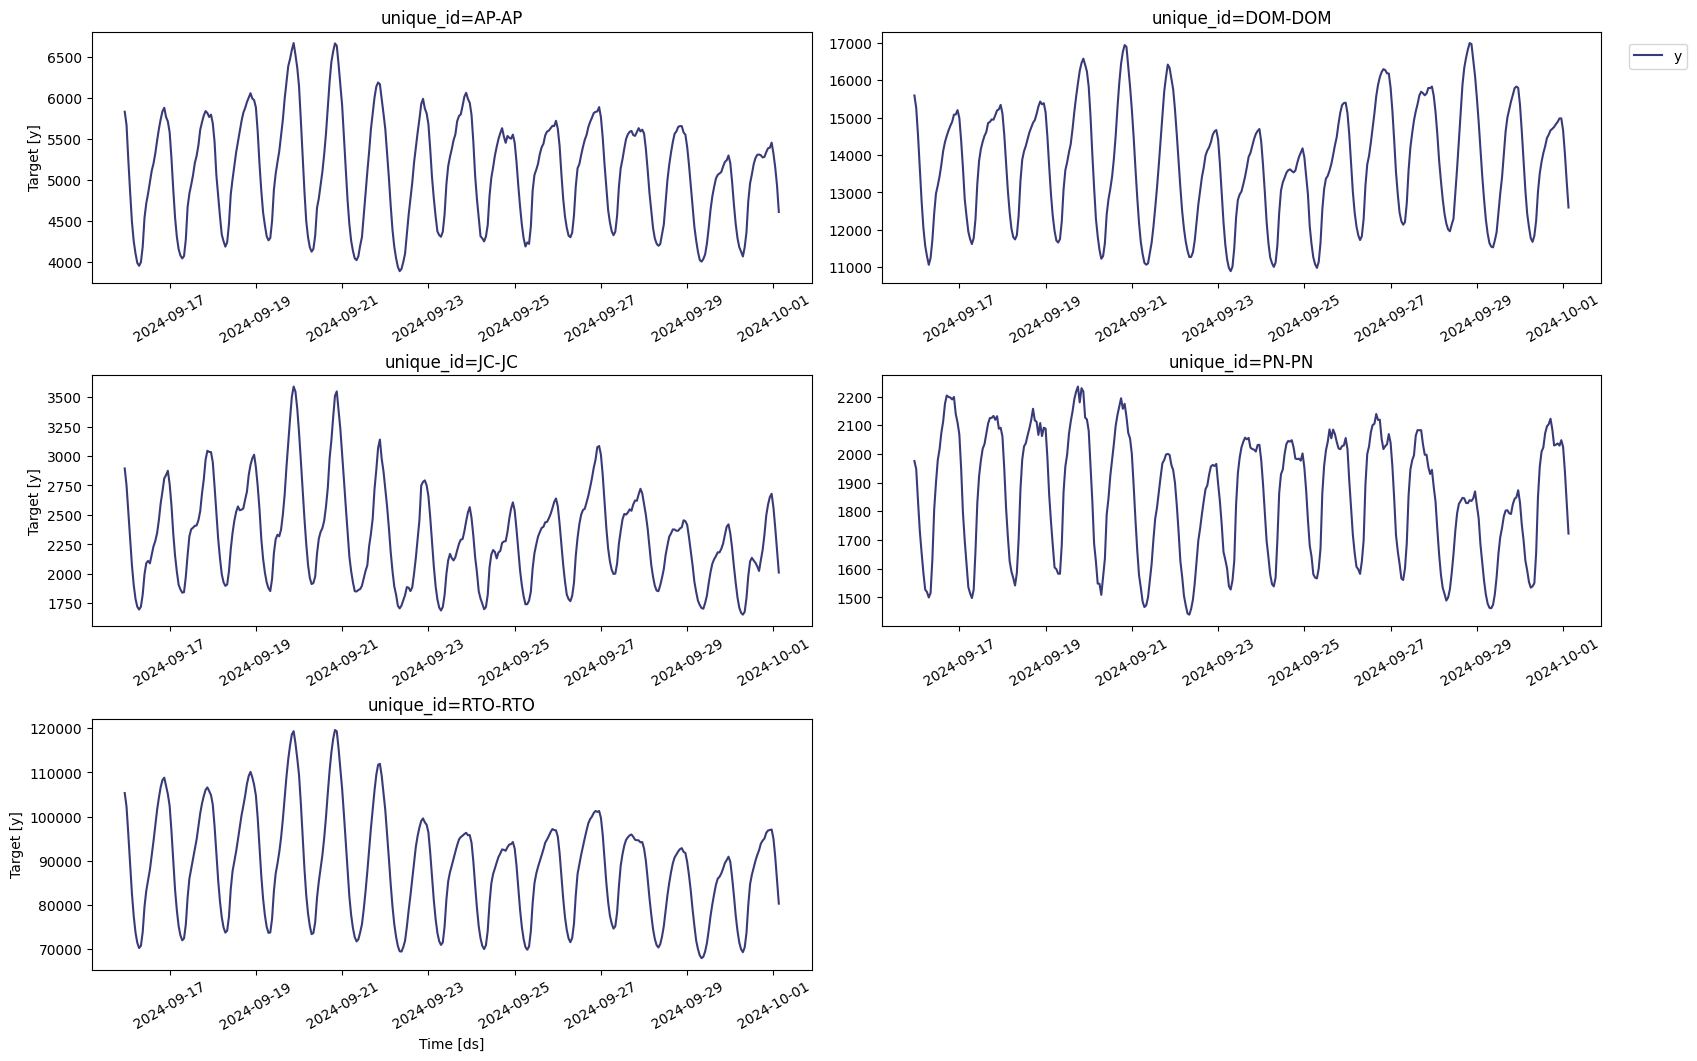

In [20]:
nixtla_client.plot(
    df,
    max_insample_length=365,
)

In [21]:
test_df = df.groupby('unique_id').tail(96)                                                             # 96 = 4 days (96 *  1 day/24h )

input_df = df.groupby('unique_id').apply(lambda group: group.iloc[-1104:-96]).reset_index(drop=True)   # 1008 = 42 days (1008 * 1 day/24h)

<ipython-input-21-1c474d0b2206>:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  input_df = df.groupby('unique_id').apply(lambda group: group.iloc[-1104:-96]).reset_index(drop=True)   # 1008 = 42 days (1008 * 1 day/24h)


In [22]:
start = time.time()

fcst_df = nixtla_client.forecast(
    df=input_df,
    h=96,
    level=[90],                        # Generate a 90% confidence interval
    finetune_steps=10,                 # Specify the number of steps for fine-tuning
    finetune_loss='mae',               # Use the MAE as the loss function for fine-tuning
    model='timegpt-1-long-horizon',    # Use the model for long-horizon forecasting
    time_col='ds',
    target_col='y',
    id_col='unique_id'
)

end = time.time()

timegpt_duration = end - start

print(f"Time (TimeGPT): {timegpt_duration}")

Time (TimeGPT): 2.8378818035125732


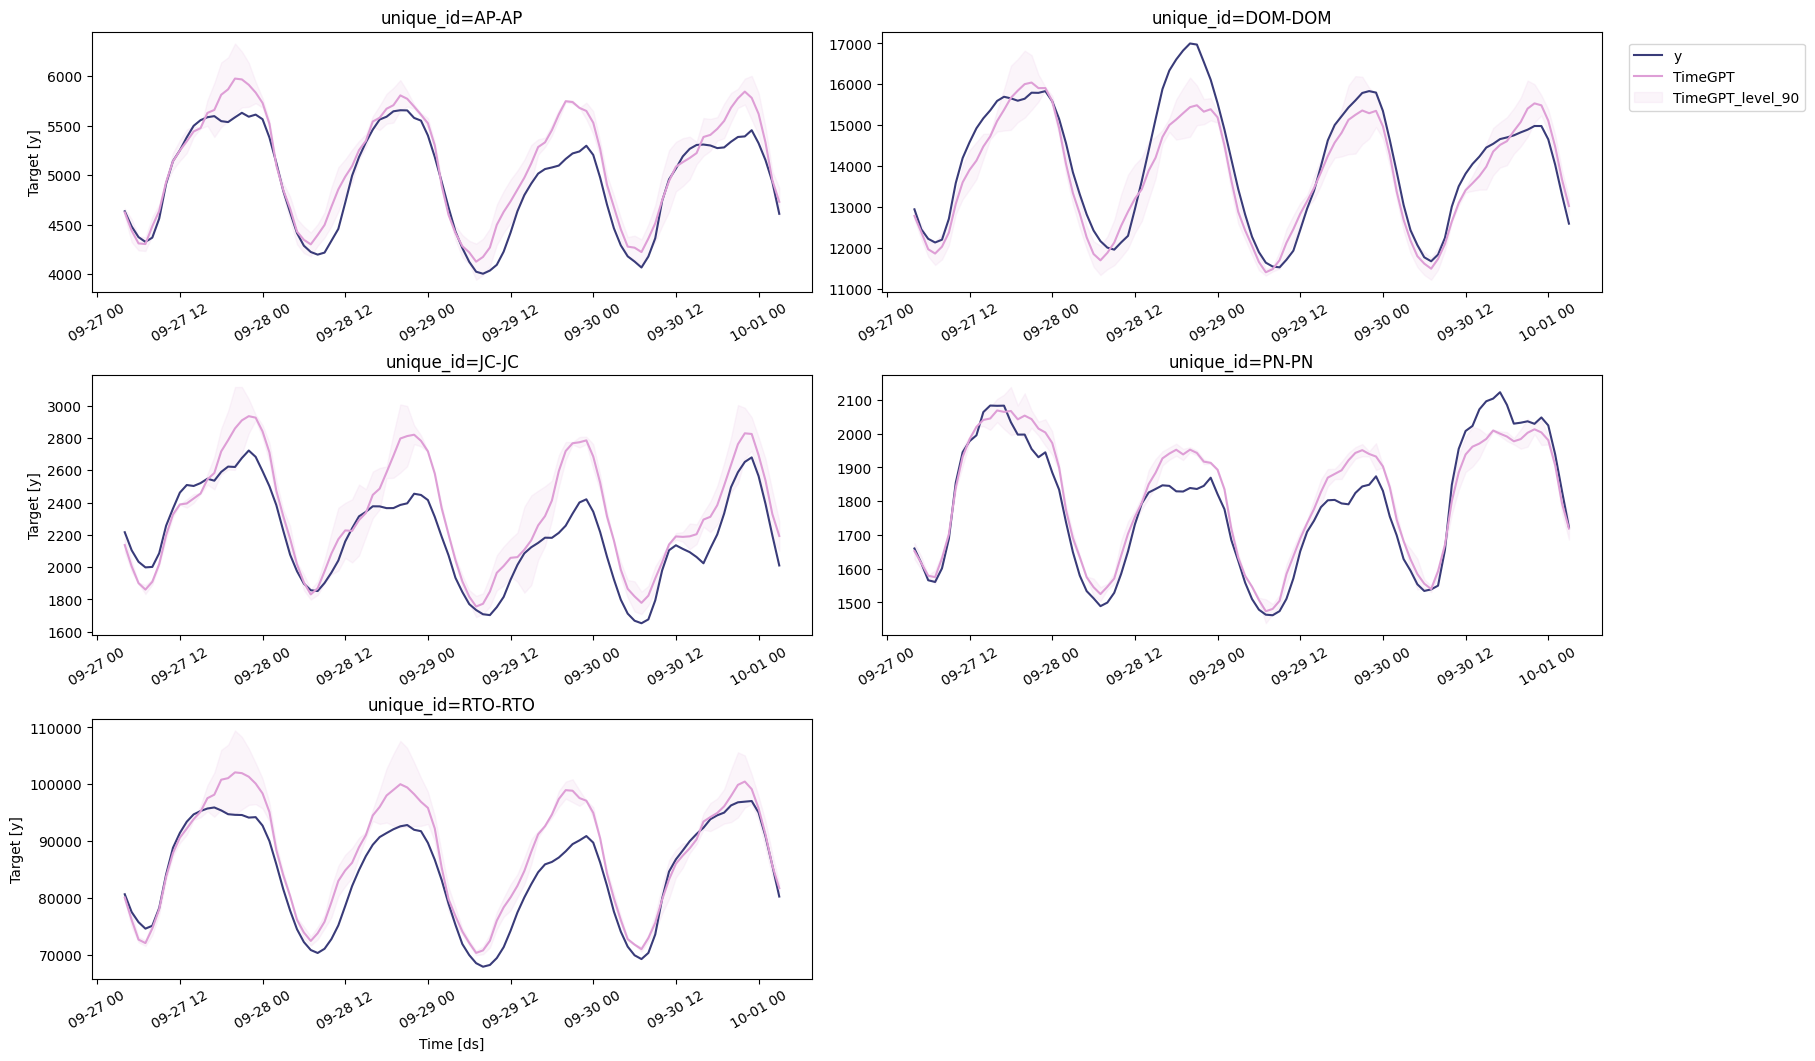

In [23]:
nixtla_client.plot(test_df, fcst_df, models=['TimeGPT'], level=[90], time_col='ds', target_col='y')

In [24]:
fcst_df['ds'] = pd.to_datetime(fcst_df['ds'])

test_df = pd.merge(test_df, fcst_df, 'left', ['unique_id', 'ds'])

In [25]:
evaluation = evaluate(
    test_df,
    metrics=[mae, smape],
    models=["TimeGPT"],
    target_col="y",
    id_col='unique_id'
)

average_metrics = evaluation.groupby('metric')['TimeGPT'].mean()
average_metrics

,TimeGPT
metric,
mae,882.526932
smape,0.019971


In [26]:
! pip install neuralforecast

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.8/254.8 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 273.5/273.5 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 27.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.3/66.3 MB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 36.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 3.9 MB/s eta 0:00:00


In [27]:
from neuralforecast.core import NeuralForecast
from neuralforecast.models import NHITS

In [28]:
train_df = df.groupby('unique_id').apply(lambda group: group.iloc[:-96]).reset_index(drop=True)

<ipython-input-28-d11dc2a3209f>:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_df = df.groupby('unique_id').apply(lambda group: group.iloc[:-96]).reset_index(drop=True)


## Bitcoin Prediction

In [31]:
import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/Nixtla/transfer-learning-time-series/main/datasets/bitcoin_price_usd.csv', sep=',')
df.head()

,Date,Close
0,2020-01-01,7200.174316
1,2020-01-02,6985.470215
2,2020-01-03,7344.884277
3,2020-01-04,7410.656738
4,2020-01-05,7411.317383


In [32]:
df.rename(columns={'Date': 'ds', 'Close': 'y'}, inplace=True)

In [33]:
level = [50,80,90] # confidence levels

fcst = nixtla_client.forecast(df, h=7, level=level)
fcst.head()

,ds,TimeGPT,TimeGPT-hi-50,TimeGPT-hi-80,TimeGPT-hi-90,TimeGPT-lo-50,TimeGPT-lo-80,TimeGPT-lo-90
0,2024-01-01,42269.460,43158.164,44109.050,44971.670,41380.758,40429.870,39567.250
1,2024-01-02,42469.918,43473.414,44361.574,45241.890,41466.420,40578.260,39697.945
2,2024-01-03,42864.080,43443.895,44141.930,45189.332,42284.260,41586.227,40538.824
3,2024-01-04,42881.620,43704.770,44547.130,45160.117,42058.473,41216.113,40603.125
4,2024-01-05,42773.457,44057.152,44881.527,45333.210,41489.760,40665.387,40213.703


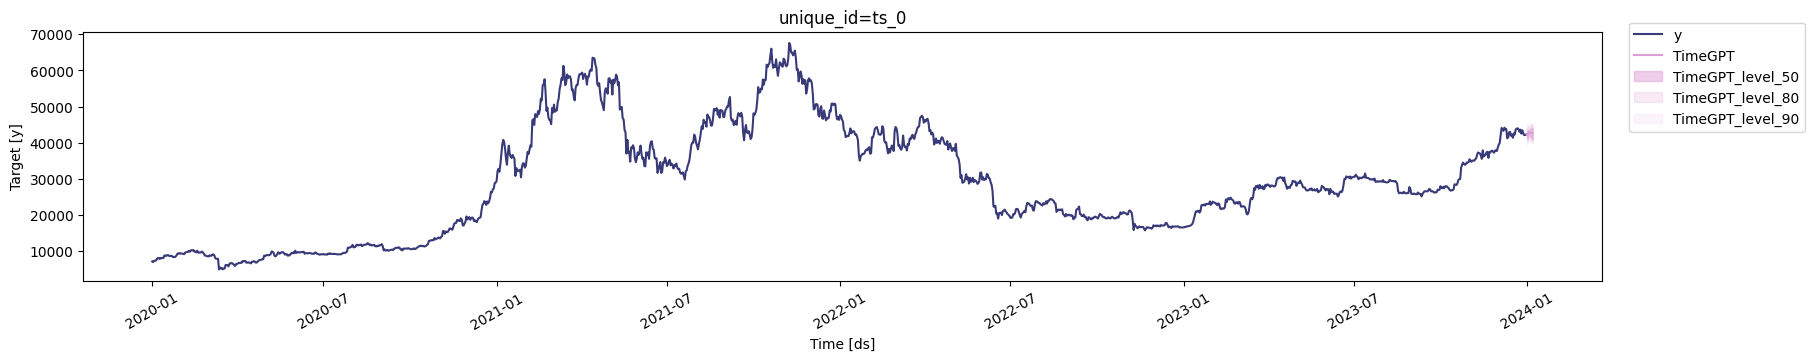

In [34]:
nixtla_client.plot(df, fcst, level=level)

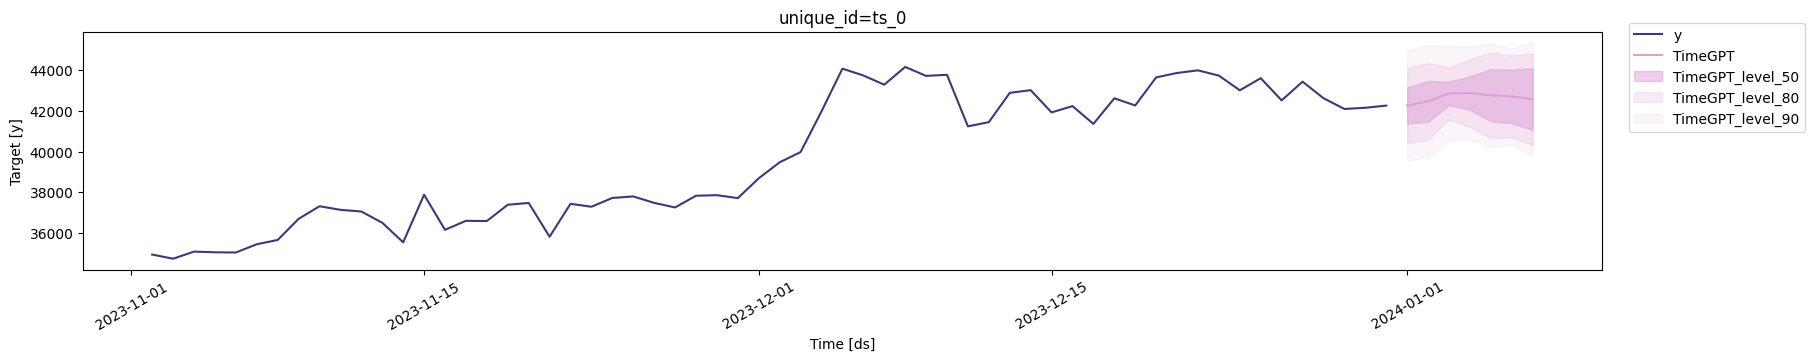

In [35]:
nixtla_client.plot(df, fcst, level=level, max_insample_length=60)

In [36]:
forecast = nixtla_client.forecast(df, h=7, level=level, add_history=True)
forecast.head()

,ds,TimeGPT,TimeGPT-hi-50,TimeGPT-hi-80,TimeGPT-hi-90,TimeGPT-lo-50,TimeGPT-lo-80,TimeGPT-lo-90
0,2020-02-03,9425.740,11229.343,12852.642,13824.121,7622.1370,5998.8384,5027.3594
1,2020-02-04,9568.520,11372.122,12995.421,13966.900,7764.9165,6141.6177,5170.1387
2,2020-02-05,9557.102,11360.704,12984.003,13955.482,7753.4985,6130.1997,5158.7207
3,2020-02-06,9486.128,11289.730,12913.029,13884.509,7682.5250,6059.2260,5087.7470
4,2020-02-07,9475.263,11278.865,12902.164,13873.644,7671.6597,6048.3610,5076.8820


In [37]:
anomalies_df = nixtla_client.detect_anomalies(df)

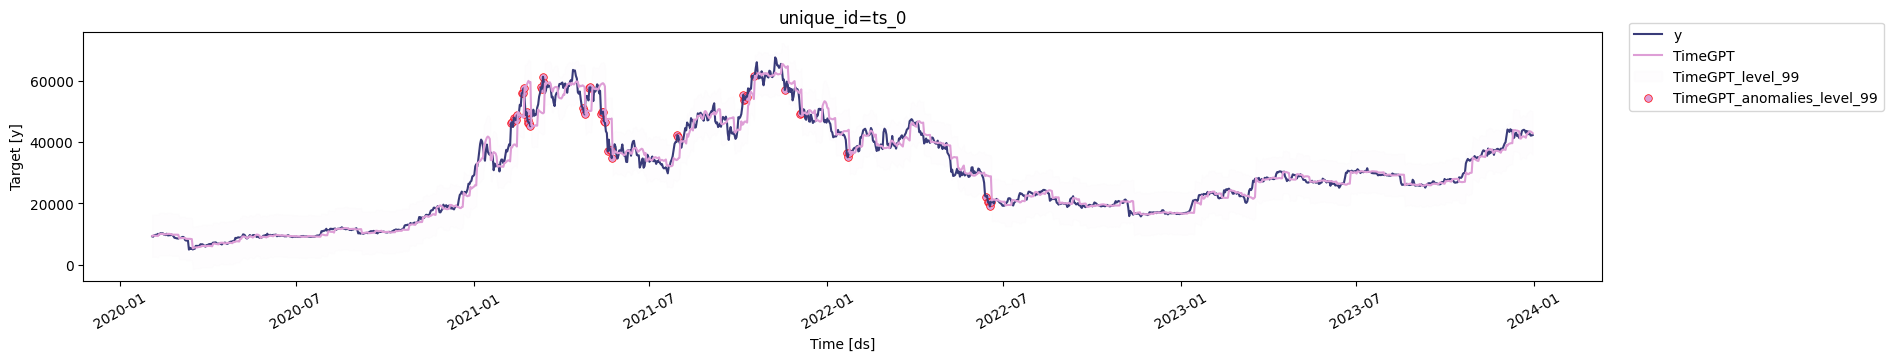

In [38]:
nixtla_client.plot(df, anomalies_df, plot_anomalies=True)